In [1]:
import rasterio
import geopandas as gpd
import numpy as np
import earthpy.spatial as es
import earthpy.plot as ep
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.plot import show
from sklearn.cluster import KMeans

In [2]:
# Load Landsat Bands (Assuming they are in individual files)
band_paths = ["C:/Users/User/Desktop/LandclassificationProject/Mat_South_Towns/Bulawayo/L812024/LC08_L2SP_171074_20240915_20240921_02_T1_SR_B2.TIF", 
              "C:/Users/User/Desktop/LandclassificationProject/Mat_South_Towns/Bulawayo/L812024/LC08_L2SP_171074_20240915_20240921_02_T1_SR_B3.TIF", 
              "C:/Users/User/Desktop/LandclassificationProject/Mat_South_Towns/Bulawayo/L812024/LC08_L2SP_171074_20240915_20240921_02_T1_SR_B4.TIF",
              "C:/Users/User/Desktop/LandclassificationProject/Mat_South_Towns/Bulawayo/L812024/LC08_L2SP_171074_20240915_20240921_02_T1_SR_B5.TIF", 
              "C:/Users/User/Desktop/LandclassificationProject/Mat_South_Towns/Bulawayo/L812024/LC08_L2SP_171074_20240915_20240921_02_T1_SR_B6.TIF",
              "C:/Users/User/Desktop/LandclassificationProject/Mat_South_Towns/Bulawayo/L812024/LC08_L2SP_171074_20240915_20240921_02_T1_SR_B7.TIF"]

In [3]:
# Read and stack the bands
bands = []
meta = None
for path in band_paths:
    with rasterio.open(path) as src:
        bands.append(src.read(1))
        if meta is None:
            meta = src.meta.copy()

In [4]:
# Stack the bands into a single array
stacked_bands = np.stack(bands)

In [5]:
# Load Shapefile (Area of Interest)
shapefile_path = "C:/Users/User/Desktop/LandclassificationProject/Mat_South_Towns/Bulawayo/Bulawayo_Shapefile/Bulawayo.shp"
shapefile = gpd.read_file(shapefile_path)

In [6]:
# Ensure CRS matches raster
with rasterio.open(band_paths[0]) as src:
    raster_crs = src.crs

if shapefile.crs != raster_crs:
    shapefile = shapefile.to_crs(raster_crs)

In [7]:
# Clip Raster with AOI Geometry
def clip_raster(raster, shapes):
    with rasterio.open(raster) as src:
        out_image, out_transform = mask(src, shapes.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({"height": out_image.shape[1], "width": out_image.shape[2], "transform": out_transform})
    return out_image, out_meta

clipped_bands = [clip_raster(path, shapefile)[0][0] for path in band_paths]
stacked_clipped = np.stack(clipped_bands)

In [8]:
# Calculate NDVI (Normalized Difference Vegetation Index)
red = stacked_clipped[3].astype(float)
nir = stacked_clipped[4].astype(float)
ndvi = (nir - red) / (nir + red)

C:\Users\User\AppData\Local\Temp\ipykernel_3120\212432716.py:4: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


In [9]:
# Calculate NDWI (Normalized Difference Water Index)
green = stacked_clipped[1].astype(float)
ndwi = (green - nir) / (green + nir)

C:\Users\User\AppData\Local\Temp\ipykernel_3120\3971572416.py:3: RuntimeWarning: invalid value encountered in divide
  ndwi = (green - nir) / (green + nir)


In [10]:
# Unsupervised Classification using K-Means
n_clusters = 5  # Define number of land cover classes
flat_pixels = stacked_clipped.reshape(stacked_clipped.shape[0], -1).T

In [11]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(flat_pixels)
classified = kmeans.labels_.reshape(stacked_clipped.shape[1:])

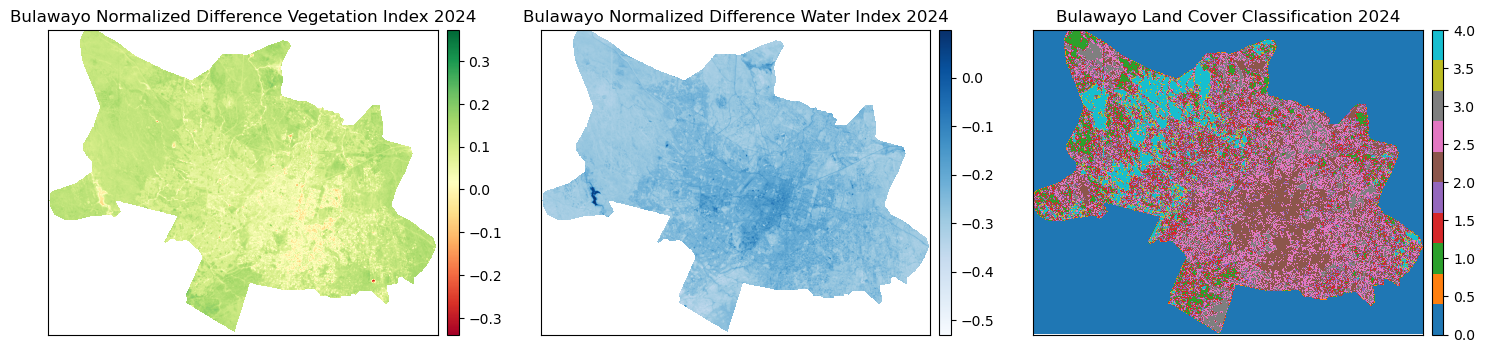

In [14]:
# Visualizations
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ep.plot_bands(ndvi, ax=ax[0], cmap='RdYlGn', title='Bulawayo Normalized Difference Vegetation Index 2024')
ep.plot_bands(ndwi, ax=ax[1], cmap='Blues', title='Bulawayo Normalized Difference Water Index 2024')
ep.plot_bands(classified, ax=ax[2], cmap='tab10', title='Bulawayo Land Cover Classification 2024')
plt.show()